In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append("../../")

from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import time
import os.path
from src.compress_sensing_library import *

In [7]:
# img_nm = 'peppers'
# load_V1 = '../../result/dwt/{img}/V1/param_db2_Mon_Apr_24_13_52_32_2023.csv'.format(img = img_nm)
# load_pixel = '../../result/dwt/{img}/pixel/param_db2_Mon_Apr_24_12_36_36_2023.csv'.format(img = img_nm)
# load_gaussian = '../../result/dwt/{img}/gaussian/param_db2_Mon_Apr_24_12_37_23_2023.csv'.format(img = img_nm)

img_nm = 'cameraman'
root = search_root()
load_V1 = '{root}/result/dct/{img}/V1/black_param_Mon_May_22_21_44_11_2023.csv'.format(root = root, img = img_nm)
load_pixel = '{root}/result/dct/{img}/pixel/black_param_Sat_May_20_18_40_40_2023.csv'.format(root = root, img = img_nm)
load_gaussian = '{root}/result/dct/{img}/gaussian/black_param_Sat_May_20_18_56_44_2023.csv'.format(root = root, img = img_nm)

In [8]:
V1_param_df = pd.read_csv(load_V1)
for index in V1_param_df.columns:
    if (index == 'Unnamed: 0') :
        V1_param_df.drop('Unnamed: 0', axis = 1, inplace=True)
V1_param_df.head(5)

pixel_param_df = pd.read_csv(load_pixel)
for index in pixel_param_df.columns:
    if (index == 'Unnamed: 0') :
        pixel_param_df.drop('Unnamed: 0', axis = 1, inplace=True)
        
gaussian_param_df = pd.read_csv(load_gaussian)
for index in gaussian_param_df.columns:
    if (index == 'Unnamed: 0') :
        gaussian_param_df.drop('Unnamed: 0', axis = 1, inplace=True)        

In [22]:
def error_colorbar(img_arr, reconst): 
    if (len(img_arr.shape) == 3):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8), dpi=200)
        fig.set_figheight(7)
        fig.set_figwidth(7)
        plt.tight_layout(h_pad=1)

        ax1.imshow(reconst, vmin = 0, vmax = 255)
        ax1.set_title("Reconst: {num_cell} cell".format(num_cell = num_cell))
        ax1.axis('off')

        err = ax2.imshow(((img_arr - reconst)**2).mean(axis = 2), 'Reds', vmin = 0, vmax = 255)
        ax2.set_title("Error: {num_cell} cells".format(num_cell = num_cell))
        ax2.axis('off')

        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(err, cax = cax2)
        # ax2.set_aspect('equal')
        # save_path = fig_save_path('peppers', 'dct', 'gaussian/filter_Reconst', "{f_n}X{f_m}_filter_{num_cell}_cell".
        #             format(f_n = filt_dim[0], f_m = filt_dim[1], num_cell = num_cell))
        # fig.savefig(save_path, dpi = 300,  bbox_inches="tight")
#         plt.show()
    else :
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8), dpi=200)
        fig.set_figheight(7)
        fig.set_figwidth(7)
        plt.tight_layout(h_pad=1)

        ax1.imshow(reconst, vmin = 0, vmax = 255)
        ax1.set_title("Reconst: {num_cell} cell".format(num_cell = num_cell))
        ax1.axis('off')

        err = ax2.imshow((img_arr - reconst), 'Reds', vmin = 0, vmax = 255)
        ax2.set_title("Error: {num_cell} cells".format(num_cell = num_cell))
        ax2.axis('off')

        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(err, cax = cax2)
        ax2.set_aspect('equal')
#         save_path = fig_save_path('peppers', 'dct', 'gaussian/filter_Reconst', "{f_n}X{f_m}_filter_{num_cell}_cell".
#                     format(f_n = filt_dim[0], f_m = filt_dim[1], num_cell = num_cell))
#         fig.savefig(save_path, dpi = 300,  bbox_inches="tight")
#         plt.show()
    return fig, ax1, ax2

# Reconstruct V1

In [12]:
V1_param_mean_df = V1_param_df.groupby(
    ['num_cell', 'sparse_freq', 'cell_size', 'alp'], as_index=False).mean().drop('rep', axis=1) 

V1_param_min_df = V1_param_mean_df.sort_values('error').drop_duplicates('num_cell')
V1_param_min_df = V1_param_min_df.rename(columns={'error': 'min_error'})
V1_merged_df = pd.merge(V1_param_df, V1_param_min_df, 
                               on=['num_cell', 'sparse_freq', 'cell_size', 'alp'], how='left')
V1_plotting_data = V1_merged_df.loc[V1_merged_df['min_error'].notnull()]

V1_min_mean_err_df = pd.DataFrame()
for i in V1_param_mean_df['num_cell'].unique():
    V1_temp = V1_param_mean_df.loc[V1_param_mean_df['num_cell'] == i]
    #hyperparameter for each number of cell
    ## Grabbing values by each values
    V1_min_mean_err_df = V1_min_mean_err_df.append(V1_temp.loc[V1_temp['error'] == V1_temp['error'].min()])
    
# Merge two data to extract
V1_min_mean_err_df = V1_min_mean_err_df.rename(columns={'error' : 'mean_err'})
V1_merged_df = pd.merge(V1_param_df, V1_min_mean_err_df, on = ['num_cell', 'sparse_freq', 'cell_size', 'alp'], how = 'left')
V1_plotting_data = V1_merged_df.loc[V1_merged_df['mean_err'].notnull()]
V1_param_min_df

num_cell  sparse_freq  cell_size    alp  min_error
87        200            6          2  10.00   2.783944
60        100            8          2   0.01   5.789301
110       500            2          2   1.00   6.487148
21         50            6          8   0.10   7.448734

Process Reconstruction on (540, 540) image


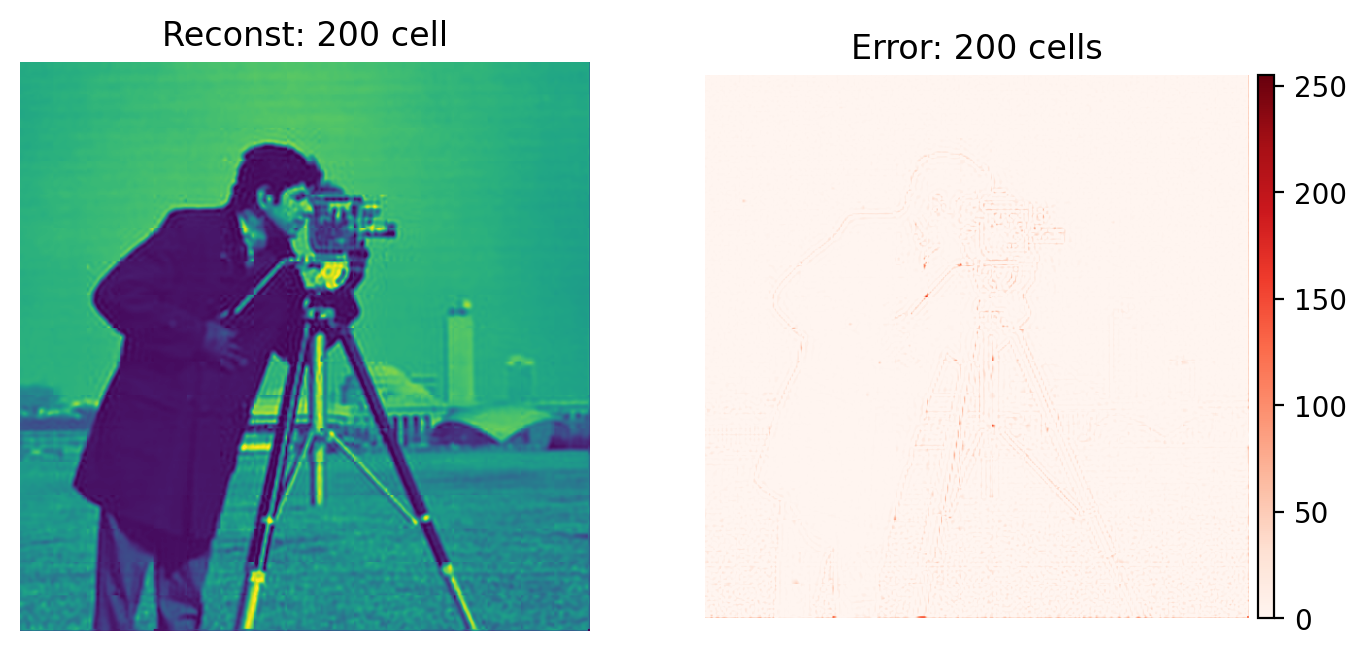

Process Reconstruction on (540, 540) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102466.54384789111, tolerance: 32236.149581669786
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126979.85231967624, tolerance: 113585.74946093521
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4728.131437211939, tolerance: 1843.6596345043417
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

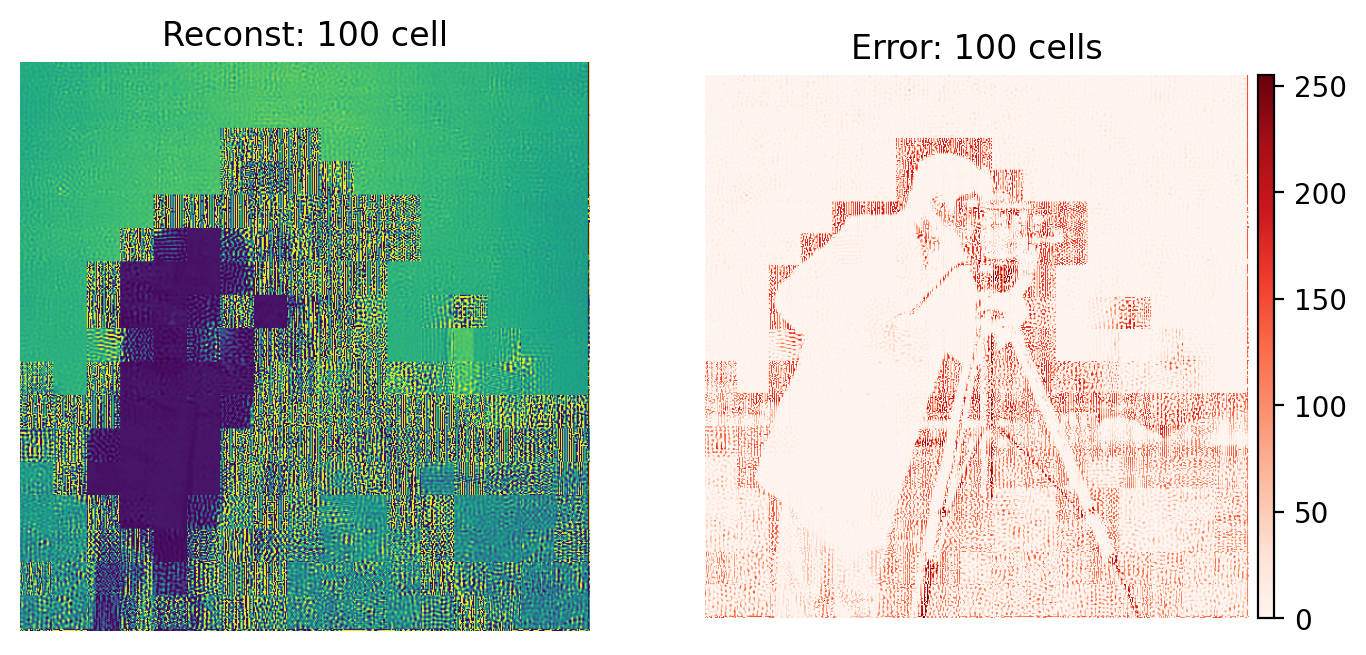

Process Reconstruction on (540, 540) image


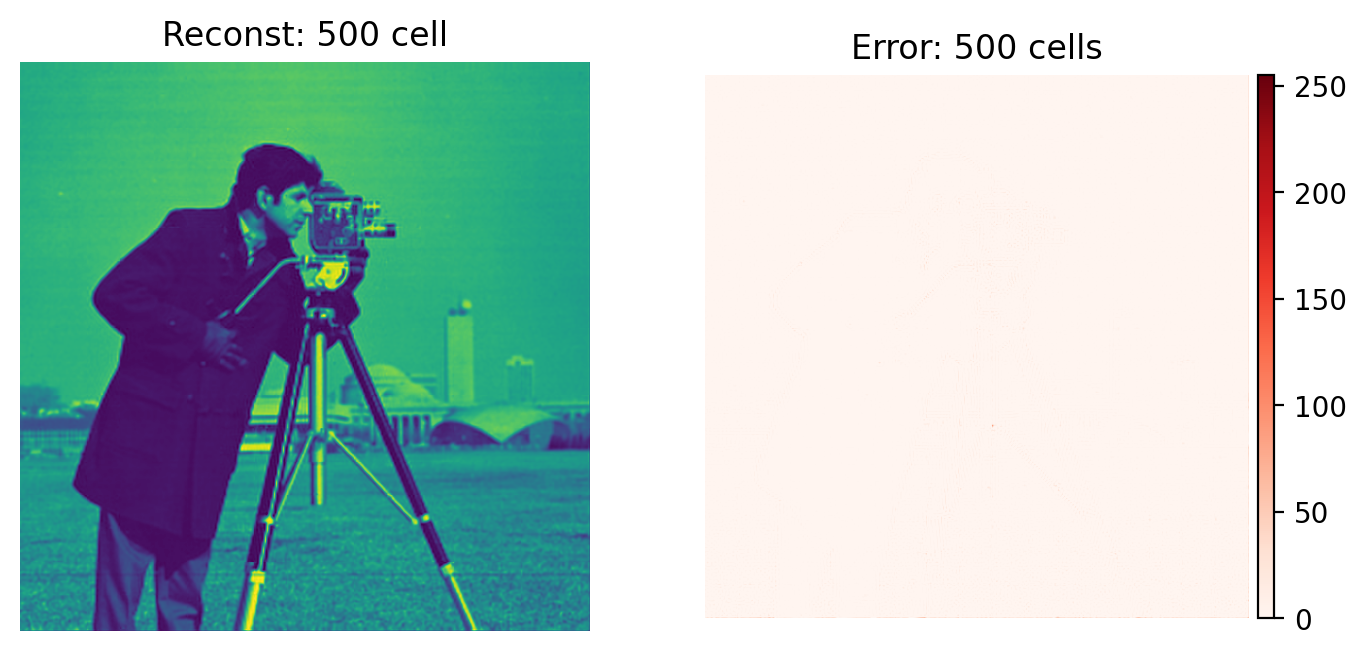

Process Reconstruction on (540, 540) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72252.18238204077, tolerance: 45168.9969884688
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42519.838771731425, tolerance: 36560.66048243406
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68507.31749337947, tolerance: 37650.13761477918
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.p

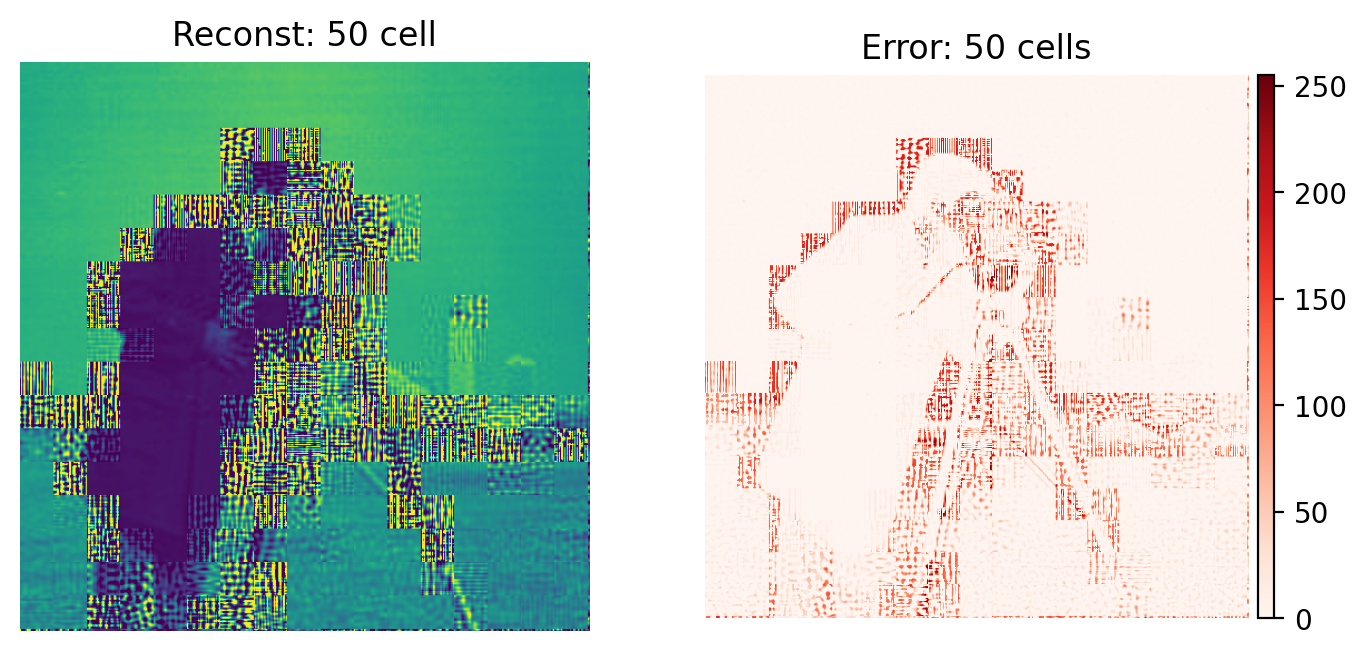

In [23]:
image_nm = 'image/cameraman.tif'
save_nm = image_nm.split('/')[1].split('.')[0]
root = search_root()
img = Image.open(os.path.join(root, image_nm))
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)
observation = 'V1'
for (num_cell, sparse_freq, cell_size, alpha, min_error) in V1_param_min_df.values:
    num_cell = int(num_cell)
    sparse_freq = int(sparse_freq)
    cell_size = int(cell_size)
    reconst = filter_reconstruct(img_arr, num_cell, cell_size, sparse_freq, alpha=alpha, method = 'dct', observation=observation)
    fig, ax1, ax2 = error_colorbar(img_arr, reconst)
    plt.show()
    #     plt.imshow(reconst)
#     error = error_calculation(img_arr, reconst)
#     print("Original Error was {min_err} and reconstructed Error is {re_err}".format(min_err = min_error, re_err = error))
#     plt.show()

# Reconstruct Pixel

In [5]:
pixel_param_mean_df = pixel_param_df.groupby(
    ['num_cell', 'alp'], as_index=False).mean().drop('rep', axis=1) 

pixel_param_min_df = pixel_param_mean_df.sort_values('error').drop_duplicates('num_cell')
pixel_param_min_df = pixel_param_min_df.rename(columns={'error': 'min_error'})
pixel_merged_df = pd.merge(pixel_param_df, pixel_param_min_df, 
                               on=['num_cell', 'alp'], how='left')
pixel_plotting_data = pixel_merged_df.loc[pixel_merged_df['min_error'].notnull()]

pixel_min_mean_err_df = pd.DataFrame()
for i in pixel_param_mean_df['num_cell'].unique():
    pixel_temp = pixel_param_mean_df.loc[pixel_param_mean_df['num_cell'] == i]
    #hyperparameter for each number of cell
    ## Grabbing values by each values
    pixel_min_mean_err_df = pixel_min_mean_err_df.append(pixel_temp.loc[pixel_temp['error'] == pixel_temp['error'].min()])
    
# Merge two data to extract
pixel_min_mean_err_df = pixel_min_mean_err_df.rename(columns={'error' : 'mean_err'})
pixel_merged_df = pd.merge(pixel_param_df, pixel_min_mean_err_df, on = ['num_cell', 'alp'], how = 'left')
pixel_plotting_data = pixel_merged_df.loc[pixel_merged_df['mean_err'].notnull()]
pixel_param_min_df

num_cell  alp  min_error
24       500  1.0  13.857664
17       200  1.0  23.384049
10       100  1.0  33.953382
3         50  1.0  45.397708

Process Reconstruction on (540, 540, 3) image
Original Error was 13.857663874629162 and reconstructed Error is 13.764819672633463


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


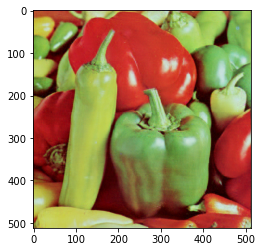

Process Reconstruction on (540, 540, 3) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21861.291327360505, tolerance: 9965.7
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48279.034032358104, tolerance: 35950.5
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32855.75171617743, tolerance: 28477.710000000003
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergence

Original Error was 23.384048707516996 and reconstructed Error is 23.163188600057335


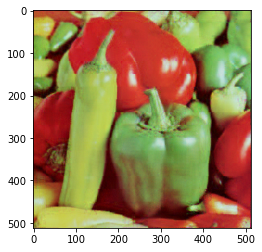

Process Reconstruction on (540, 540, 3) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25002.800103738973, tolerance: 10092.960000000001
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8547.43847612, tolerance: 3434.8500000000004
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20772.91368637935, tolerance: 17610.030000000002
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.p

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32538.318836607014, tolerance: 21717.81
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59139.38540170406, tolerance: 30817.350000000002
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6599.504431215272, tolerance: 2570.4900000000002
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

Original Error was 33.95338178667211 and reconstructed Error is 33.81154260319999


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


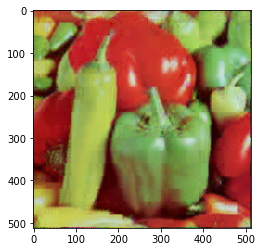

Process Reconstruction on (540, 540, 3) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60145.05248005965, tolerance: 53484.75
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31555.44339079052, tolerance: 28580.13
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63365.4607537292, tolerance: 59784.21000000001
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceW

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43304.6611463583, tolerance: 29171.97
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12752.38631353902, tolerance: 3042.0
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31280.831733308638, tolerance: 9394.11
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Obj

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.95037216104254, tolerance: 384.21000000000004
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18186.19350630806, tolerance: 11338.470000000001
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110689.19669052403, tolerance: 76232.25
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44312.87448993915, tolerance: 29011.32
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14125.09515918496, tolerance: 13444.74
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45345.75938182718, tolerance: 19999.620000000003
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33116.765092224305, tolerance: 20183.31
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20871.643485112658, tolerance: 19704.24
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Converge

Original Error was 45.39770796447114 and reconstructed Error is 45.29465022549896


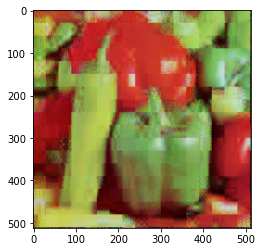

In [10]:
image_nm = 'image/peppers.png'
save_nm = image_nm.split('/')[1].split('.')[0]
root = search_root()
img = Image.open(os.path.join(root, image_nm))
# img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

for (num_cell, alpha, min_error) in pixel_param_min_df.values:
    num_cell = int(num_cell)
    reconst = filter_reconstruct(img_arr, num_cell, alpha=alpha, method = 'dct', observation = 'pixel', mode = 'color')
    plt.imshow(reconst)
    error = error_calculation(img_arr, reconst)
    print("Original Error was {min_err} and reconstructed Error is {re_err}".format(min_err = min_error, re_err = error))
    plt.show()

# Gaussian

In [12]:
gaussian_param_mean_df = gaussian_param_df.groupby(
    ['num_cell', 'alp'], as_index=False).mean().drop('rep', axis=1) 

gaussian_param_min_df = gaussian_param_mean_df.sort_values('error').drop_duplicates('num_cell')
gaussian_param_min_df = gaussian_param_min_df.rename(columns={'error': 'min_error'})
gaussian_merged_df = pd.merge(gaussian_param_df, gaussian_param_min_df, 
                               on=['num_cell', 'alp'], how='left')
gaussian_plotting_data = gaussian_merged_df.loc[gaussian_merged_df['min_error'].notnull()]

gaussian_min_mean_err_df = pd.DataFrame()
for i in gaussian_param_mean_df['num_cell'].unique():
    gaussian_temp = gaussian_param_mean_df.loc[gaussian_param_mean_df['num_cell'] == i]
    #hyperparameter for each number of cell
    ## Grabbing values by each values
    gaussian_min_mean_err_df = gaussian_min_mean_err_df.append(gaussian_temp.loc[gaussian_temp['error'] == gaussian_temp['error'].min()])
    
# Merge two data to extract
gaussian_min_mean_err_df = gaussian_min_mean_err_df.rename(columns={'error' : 'mean_err'})
gaussian_merged_df = pd.merge(gaussian_param_df, gaussian_min_mean_err_df, on = ['num_cell', 'alp'], how = 'left')
gaussian_plotting_data = gaussian_merged_df.loc[gaussian_merged_df['mean_err'].notnull()]
gaussian_param_min_df

num_cell  alp  min_error
24       500  1.0  13.837411
17       200  1.0  23.386818
10       100  1.0  33.943164
3         50  1.0  45.286284

Process Reconstruction on (540, 540, 3) image
Original Error was 13.857663874629162 and reconstructed Error is 10.825199849528255


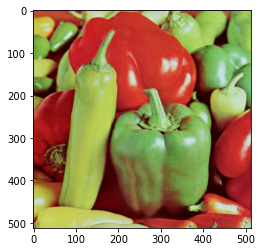

Process Reconstruction on (540, 540, 3) image
Original Error was 23.384048707516996 and reconstructed Error is 21.259980674009967


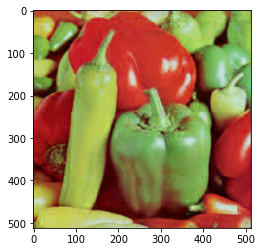

Process Reconstruction on (540, 540, 3) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29676.409861952616, tolerance: 20443.091785383018
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79894.99543715785, tolerance: 71565.4580897659
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86272.26943025221, tolerance: 77886.27155000277
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

Original Error was 33.95338178667211 and reconstructed Error is 31.62575623584381


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1752.8397355398965, tolerance: 1492.3976443267993
  model = cd_fast.enet_coordinate_descent(


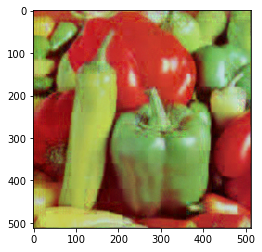

Process Reconstruction on (540, 540, 3) image


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15968.413899293928, tolerance: 15519.423768902574
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59438.12230743984, tolerance: 28135.705813310346
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60196.74561226138, tolerance: 54745.26945389345
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38587.54754580713, tolerance: 24858.779874805587
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6464.250758937253, tolerance: 3702.828437047701
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14623.402568751482, tolerance: 8601.500479841117
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27839.122809074437, tolerance: 8160.385697511231
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6565.145347879038, tolerance: 3524.6531046550695
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6395.112700307582, tolerance: 4113.409960626731
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22734.25996939276, tolerance: 11924.011187682665
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30814.705037350603, tolerance: 10793.092054597624
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52847.70200709698, tolerance: 22697.767368598325
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

Original Error was 45.39770796447114 and reconstructed Error is 44.122326345733676


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006.5616334678432, tolerance: 732.5531897935149
  model = cd_fast.enet_coordinate_descent(


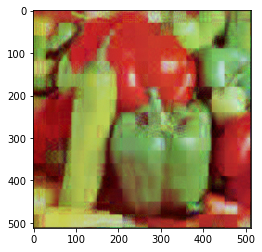

In [13]:

TypeError: 'builtin_image_nm = 'image/peppers.png'
save_nm = image_nm.split('/')[1].split('.')[0]
root = search_root()
img = Image.open(os.path.join(root, image_nm))
# img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

for (num_cell, alpha, min_error) in pixel_param_min_df.values:
    num_cell = int(num_cell)
    reconst = filter_reconstruct(img_arr, num_cell, alpha=alpha, method = 'dct', observation = 'gaussian', mode = 'color')
    plt.imshow(reconst)
    error = error_calculation(img_arr, reconst)
    print("Original Error was {min_err} and reconstructed Error is {re_err}".format(min_err = min_error, re_err = error))
    plt.show()

In [2]:
obs_dict= {'V1': 1,
               'gaussian': 2, 
               'pixel': 3
              }

In [4]:
obs_dict.get('V1')

1

In [7]:
method, img_nm, observation, file = 'result/dct/peppers/V1/black_param_Mon_May_22_21_44_11_2023.csv'.split('/')[1:]

In [14]:
obs_dict['V1'] = 10
obs_dict['V1]



NameError: name 'V1' is not defined

In [23]:
for obs, item in obs_dict.items():
    print (obs, item)

V1 10
gaussian 2
pixel 3


In [26]:
img_nm = 'cameraman'
root = search_root()
load_V1 = '{root}/result/dct/{img}/V1/black_param_Mon_May_22_21_44_11_2023.csv'.format(root = root, img = img_nm)
load_pixel = '{root}/result/dct/{img}/pixel/black_param_Sat_May_20_18_40_40_2023.csv'.format(root = root, img = img_nm)
load_gaussian = '{root}/result/dct/{img}/gaussian/black_param_Sat_May_20_18_56_44_2023.csv'.format(root = root, img = img_nm)

In [28]:
def remove_unnamed_data(data):
    for index in V1_param_df.columns:
        if (index == 'Unnamed: 0') :
            data.drop('Unnamed: 0', axis = 1, inplace=True)
    return data

obs_dict= {'V1': pd.read_csv(load_V1),
               'gaussian': pd.read_csv(load_gaussian), 
               'pixel': pd.read_csv(load_pixel), 
              }
for obs, file in obs_dict.items():
    obs_dict.update({obs: remove_unnamed_data(file)})
print(obs_dict.get('V1').head(5))

NameError: name 'index' is not defined